# GLM Demo: multivariate noise stimulus

This is a demo notebook for the GLM estimation algorithm. We simulate data using the GLM, and then try to estimate parameters with the GLM. This notebook demos the use of a multivariate stimulus like a spectrogram, although the stimulus used here is more like 1D visual white noise.

In [16]:
from __future__ import print_function, division
import os
import sys
import numpy as np

import mat_neuron._model as mat
from dstrf import strf, mle, simulate, filters, models

# plotting packages
%reload_ext yamlmagic
%matplotlib inline
import matplotlib.pyplot as plt # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

cfg = {}

Set up parameters using YAML and Munch

In [17]:
%%yaml cfg
model:
  dt: 0.5
  ataus: [10.0, 200.0]
  t_refract: 2.0
  filter:
    rank: 2
    len: 30
    ncos: 8
data:
  filter:
    fn: "gabor"
    nfreq: 14
    ntau: 30
    f_max: 8000
    f_peak: 4000
    t_peak: 12
    ampl: -1
    t_sigma: 6
    f_sigma: 2400
    theta: 0
    lmbda: 19
    psi: 1.5
  adaptation: [7.0, 100.0, 2.0]
  trial_noise:
    sd: 2.0
  random_seed: 1
  dt: 10.0
  duration: 400000
  trials: 10

<IPython.core.display.Javascript object>

In [18]:
from munch import munchify
cf = munchify(cfg)

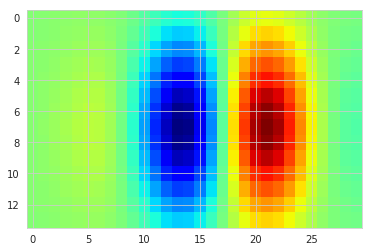

In [19]:
k1, _, _ = filters.gabor(**cf.data.filter)
plt.imshow(k1, cmap='jet', aspect='auto');

The simulation code has been factored out to the `simulate` module.

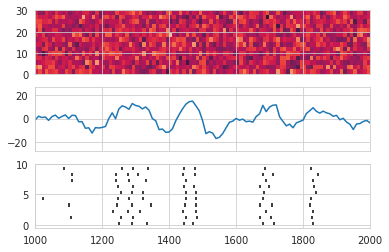

In [20]:
assim_data = simulate.multivariate_noise_glm(cf)
t_stim = np.arange(0, cf.data.duration, cf.data.dt)

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6, 4))
axes[0].imshow(assim_data[0]["stim"], extent=(0, cf.data.duration, 0, cf.data.filter.ntau), 
               origin='lower', aspect='auto')
axes[1].plot(t_stim, assim_data[0]["V"])
for i, d in enumerate(assim_data):
    axes[2].vlines(d["spike_t"] * cf.model.dt, i, i + 0.5)

axes[0].set_xlim(1000, 2000);

## Estimate parameters

First we'll estimate the full RF (using the raised cosine basis set to compress time)

In [ ]:
# initial guess of parameters using ML
kcosbas = strf.cosbasis(cf.model.filter.len, cf.model.filter.ncos)
stim_dt = cf.data.dt
model_dt = cf.model.dt
stim = assim_data[0]["stim"]
spike_v = np.stack([d["spike_v"] for d in assim_data], axis=1)
spike_h = np.stack([d["H"] for d in assim_data], axis=2)
try:
    mlest = mle.mat(stim, kcosbas, spike_v, spike_h, stim_dt, model_dt, nlin="exp")
except TypeError:
    mlest = mle.mat(stim, kcosbas, spike_v, spike_h, stim_dt, model_dt, nlin="exp")
%time w0 = mlest.estimate()

In [ ]:
print("True rate and adaptation parameters:", cf.data.adaptation)
print("MLE rate and adaptation parameters:", w0[:3])
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(6, 6))

k1c = strf.to_basis(k1, kcosbas)
rf_sta = strf.as_matrix(mlest.sta(), kcosbas)
rf_mle = strf.as_matrix(w0[3:], kcosbas)
axes[0, 0].imshow(k1, cmap='jet', aspect='auto')
axes[0, 0].set_title("True RF")
axes[0, 1].imshow(strf.from_basis(k1c, kcosbas), cmap='jet', aspect='auto')
axes[0, 1].set_title("RF from cosine basis")
axes[1, 0].imshow(rf_sta, cmap='jet', aspect='auto')
axes[1, 0].set_title("STA")
axes[1, 1].imshow(rf_mle, cmap='jet', aspect='auto')
axes[1, 1].set_title("MLE")

We can also reduce parameter counts by factorizing the STRF (as in Thorson et al). This doesn't make much of a difference with white noise stimuli but it can really help when there are strong correlations.

In [ ]:
krank = 1
mlest = mle.matfact(stim, kcosbas, krank, spike_v, spike_h, stim_dt, model_dt, nlin="exp")
%time w0 = mlest.estimate()

In [ ]:
print("True rate and adaptation parameters:", cf.data.adaptation)
print("MLE rate and adaptation parameters:", w0[:3])
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(6, 6))

k1c = strf.to_basis(k1, kcosbas)
rf_sta = strf.as_matrix(mlest.sta(), kcosbas)
rf_mle = strf.from_basis(strf.defactorize(w0[3:], cf.data.filter.nfreq, krank), kcosbas)
axes[0, 0].imshow(k1, cmap='jet', aspect='auto')
axes[0, 0].set_title("True RF")
axes[0, 1].imshow(strf.from_basis(k1c, kcosbas), cmap='jet', aspect='auto')
axes[0, 1].set_title("RF from cosine basis")
axes[1, 0].imshow(rf_sta, cmap='jet', aspect='auto')
axes[1, 0].set_title("STA")
axes[1, 1].imshow(rf_mle, cmap='jet', aspect='auto')
axes[1, 1].set_title("MLE (rank-{})".format(krank));

## Predict responses

In [ ]:
test_trials = 10
test_data = simulate.multivariate_noise_glm(cf, random_seed=1000, trials=test_trials)
tstim = test_data[0]["stim"]
tspike_v = np.stack([d["spike_v"] for d in test_data], axis=1)
tspike_h = np.stack([d["H"] for d in test_data], axis=2)

mltest = mle.matfact(tstim, kcosbas, krank, tspike_v, tspike_h, stim_dt, model_dt, nlin="exp")

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6, 4))
axes[0].imshow(assim_data[0]["stim"], extent=(0, cf.data.duration, 0, cf.data.filter.ntau), 
               origin='lower', aspect='auto')
axes[1].plot(t_stim, test_data[0]["V"])
V = mltest.V(w0)
for i in range(test_trials):
    S = models.predict_spikes_glm(V, w0[:3], cf)
    axes[2].vlines(S.nonzero()[0] * model_dt, i - 0.4, i + 0.4)
for i, d in enumerate(test_data):
    axes[2].vlines(d["spike_t"] * model_dt, i - 0.4 + test_trials, i + 0.4 + test_trials, color="r")

axes[2].set_xlim(0, 5000);